<a href="https://colab.research.google.com/github/R1SHABHRAJ/Soccer-Analysis-and-Visualization-using-VAEP-and-XGBoost/blob/main/SoccerProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Libraries

In [1]:
!pip install tables
!pip install matplotsoccer
!pip install socceraction==0.2.0

  Preparing metadata (setup.py) ... done
  Created wheel for matplotsoccer: filename=matplotsoccer-0.0.8-py3-none-any.whl size=5966 sha256=bccc6c0ee94b03f91e9c012c4b4f967125de063d3e80f109c2863f343074379a
  Stored in directory: /root/.cache/pip/wheels/ef/a9/d2/796b0ad28ffe440216ddaf7c9aa570dbdbfd67c3b208fd07ca
Successfully built matplotsoccer
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 8.4 MB/s eta 0:00:00
  Created wheel for socceraction: filename=socceraction-0.2.0-py3-none-any.whl size=30641 sha256=a9178c291219995b6785549eee9189ee0216c6cce6ff7ae192337da445d3993c
  Stored in directory: /root/.cache/pip/wheels/53/cd/73/194cae13cd5b3448a32f952f684ff7038a7afd183e542c5bb1
Successfully built socceraction


In [2]:
# This was for fetching dataset from my google drive, but since your drive doesn't have dataset already it will not work
'''from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/My Drive/dataset/'''
# So we will fetch dataset Wyscount dataset directly from the source
import gdown
!mkdir /content/dataset
!gdown --folder 1xoA3XO35ZFIM870eN9wMt6mHmZqHRx7F --output /content/dataset

Retrieving folder contents
Retrieving folder 10iWAFxjXfepGlnvoM5cW5fnFjAOC36IJ .ipynb_checkpoints
Retrieving folder 1fAcjgPdhChcVU_gy2ieONNlyZPba8sgO metrica
Retrieving folder 1-TsfIZ7ZaqijEDYLiklTHu9ZwPxCZOow __pycache__
Processing file 1-qbOjLoR07jro9ZBWOni7An2VNFSwQeF Metrica_EPV.cpython-310.pyc
Processing file 1-ceDd9j9l02YsSPEV_3BetDR9b47vm1j Metrica_IO.cpython-310.pyc
Processing file 1-rEBkf_RrmJU9PK13779bqcWt7njW1iC Metrica_PitchControl.cpython-310.pyc
Processing file 1-aXQFtBJ41b2zRFJnBnxJy5M5uIsrpS8 Metrica_Velocities.cpython-310.pyc
Processing file 1-cJKl5P9Vs606brW7Sih2K24-p0vBfpN Metrica_Viz.cpython-310.pyc
Processing file 1CqdNQAtJxRjHJ1nkgQSiQ7s9fol74ads Metrica_EPV.py
Processing file 1GeTSkajWYkV9aMMUc-hIJ_rg7oKYW2BU Metrica_IO.py
Processing file 1pAHS0K_H-PUQ3zGC8Ufwx8GInqRJLrm3 Metrica_PitchControl.py
Processing file 1m1E9Nb6L49XTknZc9IRr-hHwmeyWwnbQ Metrica_Velocities.py
Processing file 1jASSqHzxS-YL8nLQpF9JsA_k_8rLdguC Metrica_Viz.py
Retrieving folder 1fISh7AeQ7cs8If

In [3]:
'''!mkdir /content/dataset
!gdown --folder 1xoA3XO35ZFIM870eN9wMt6mHmZqHRx7F --output /content/dataset
%cd '/content/dataset/'''

"!mkdir /content/dataset\n!gdown --folder 1xoA3XO35ZFIM870eN9wMt6mHmZqHRx7F --output /content/dataset\n%cd '/content/dataset/"

In [4]:
#Signality libraries for tracking data
'''%cd /content/dataset/signality
import Signality_IO as sio
import Signality_Viz as sviz
import Signality_Velocities as svel
import Signality_PitchControl as spc
import Signality_EPV as sepv

%cd /content/dataset/metrica
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import Metrica_PitchControl as mpc
import Metrica_EPV as mepv'''

'%cd /content/dataset/signality\nimport Signality_IO as sio\nimport Signality_Viz as sviz\nimport Signality_Velocities as svel\nimport Signality_PitchControl as spc\nimport Signality_EPV as sepv\n\n%cd /content/dataset/metrica\nimport Metrica_IO as mio\nimport Metrica_Viz as mviz\nimport Metrica_Velocities as mvel\nimport Metrica_PitchControl as mpc\nimport Metrica_EPV as mepv'

In [3]:
%cd '/content/dataset'
import warnings

import matplotsoccer
import numpy as np
from ipywidgets import fixed, interact_manual, widgets

from io import BytesIO
from pathlib import Path
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile

import pandas as pd
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels
from sklearn.metrics import brier_score_loss, roc_auc_score
from socceraction.spadl.wyscout import convert_to_spadl
from socceraction.vaep.formula import value
from tqdm.notebook import tqdm
from xgboost import XGBClassifier

/content/dataset


In [4]:
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

## Preprocess the dataset

In [5]:
def read_json_file(filename):
    with open(filename, 'rb') as json_file:
        return BytesIO(json_file.read()).getvalue().decode('unicode_escape')

### Teams

The following cells read the `teams.json` file into a `DataFrame` object and store that object in the `data.h5` H5 file under the key `teams`.

In [6]:
%cd /content/dataset
json_teams = read_json_file('teams.json')
df_teams = pd.read_json(json_teams)
df_teams.head(10)

/content/dataset


,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alavés,696,Deportivo Alavés,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
5,Troyes,Troyes,3795,Espérance Sportive Troyes Aube Champagne,"{'name': 'France', 'id': '250', 'alpha3code': ...",club
6,Getafe (Madrid),Getafe,698,Getafe Club de Fútbol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
7,Mönchengladbach,Borussia M'gladbach,2454,Borussia VfL Mönchengladbach,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
8,"Huddersfield, West Yorkshire",Huddersfield Town,1673,Huddersfield Town FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
9,Bilbao,Athletic Club,678,Athletic Club Bilbao,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


In [7]:
df_teams.to_hdf('data.h5', key='teams', mode='w')

### Players

The following cells read the `players.json` file into a `DataFrame` object and store that object in the `data.h5` HDF5 file under the key `players`.

In [8]:
json_players = read_json_file('players.json')
df_players = pd.read_json(json_players)
df_players.head(10)

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,,Konaté,2975,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konaté,null
5,"{'name': 'Netherlands', 'id': '528', 'alpha3co...",83,Jasper,,Cillessen,676,1989-04-22,185,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Netherlands', 'id': '528', 'alpha3co...",33,right,J. Cillessen,664
6,"{'name': 'Belgium', 'id': '56', 'alpha3code': ...",91,Toby,,Alderweireld,1624,1989-03-02,187,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Belgium', 'id': '56', 'alpha3code': ...",36,right,T. Alderweireld,5629
7,"{'name': 'Belgium', 'id': '56', 'alpha3code': ...",88,Jan,,Vertonghen,1624,1987-04-24,189,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Belgium', 'id': '56', 'alpha3code': ...",48,left,J. Vertonghen,5629
8,"{'name': 'France', 'id': '250', 'alpha3code': ...",74,Alexander,,Djiku,3783,1994-08-09,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",229427,right,A. Djiku,null
9,"{'name': 'Denmark', 'id': '208', 'alpha3code':...",76,Christian,,Dannemann Eriksen,1624,1992-02-14,180,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Denmark', 'id': '208', 'alpha3code':...",54,right,C. Eriksen,7712


In [9]:
df_players.to_hdf('data.h5', key='players', mode='a')

### Matches

The following cell lists the competitions to be included in the dataset. We can comment any number of the competitions to include in our dataset.

In [10]:
competitions = [
#     'England',
#     'France',
#     'Germany',
#     'Italy',
    'Spain',
    'European Championship',
    'World Cup'
]

In [11]:
dfs_matches = []
for competition in competitions:
    competition_name = competition.replace(' ', '_')
    file_matches = f'matches_{competition_name}.json'
    json_matches = read_json_file(file_matches)
    df_matches = pd.read_json(json_matches)
    dfs_matches.append(df_matches)
df_matches = pd.concat(dfs_matches)
df_matches.head(10)

/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId,groupName
0,Played,4406122,38,"{'676': {'scoreET': 0, 'coachId': 92894, 'side...",181144,2018-05-20 18:45:00,676,Camp Nou,2565922,"Barcelona - Real Sociedad, 1 - 0","May 20, 2018 at 8:45:00 PM GMT+2","[{'refereeId': 398931, 'role': 'referee'}, {'r...",Regular,795,NaN
1,Played,4406122,38,"{'679': {'scoreET': 0, 'coachId': 3427, 'side'...",181144,2018-05-20 16:30:00,0,Estadio Wanda Metropolitano,2565925,"Atlético Madrid - Eibar, 2 - 2","May 20, 2018 at 6:30:00 PM GMT+2","[{'refereeId': 395056, 'role': 'referee'}, {'r...",Regular,795,NaN
2,Played,4406122,38,"{'691': {'scoreET': 0, 'coachId': 444778, 'sid...",181144,2018-05-20 14:15:00,691,San Mamés Barria,2565919,"Athletic Club - Espanyol, 0 - 1","May 20, 2018 at 4:15:00 PM GMT+2","[{'refereeId': 384957, 'role': 'referee'}, {'r...",Regular,795,NaN
3,Played,4406122,38,"{'674': {'scoreET': 0, 'coachId': 210074, 'sid...",181144,2018-05-20 10:00:00,674,Estadio de Mestalla,2565924,"Valencia - Deportivo La Coruña, 2 - 1","May 20, 2018 at 12:00:00 PM GMT+2","[{'refereeId': 398913, 'role': 'referee'}, {'r...",Regular,795,NaN
4,Played,4406122,38,"{'675': {'scoreET': 0, 'coachId': 275283, 'sid...",181144,2018-05-19 18:45:00,0,Estadio de la Cerámica,2565927,"Villarreal - Real Madrid, 2 - 2","May 19, 2018 at 8:45:00 PM GMT+2","[{'refereeId': 395085, 'role': 'referee'}, {'r...",Regular,795,NaN
5,Played,4406122,38,"{'696': {'scoreET': 0, 'coachId': 230918, 'sid...",181144,2018-05-19 16:30:00,680,Estadio Ramón Sánchez Pizjuán,2565920,"Sevilla - Deportivo Alavés, 1 - 0","May 19, 2018 at 6:30:00 PM GMT+2","[{'refereeId': 379388, 'role': 'referee'}, {'r...",Regular,795,NaN
6,Played,4406122,38,"{'698': {'scoreET': 0, 'coachId': 4107, 'side'...",181144,2018-05-19 16:30:00,698,Estadio La Rosaleda,2565921,"Málaga - Getafe, 0 - 1","May 19, 2018 at 6:30:00 PM GMT+2","[{'refereeId': 398919, 'role': 'referee'}, {'r...",Regular,795,NaN
7,Played,4406122,38,"{'714': {'scoreET': 0, 'coachId': 4258, 'side'...",181144,2018-05-19 16:30:00,756,Estadio de Gran Canaria,2565923,"Las Palmas - Girona, 1 - 2","May 19, 2018 at 6:30:00 PM GMT+2","[{'refereeId': 381854, 'role': 'referee'}, {'r...",Regular,795,NaN
8,Played,4406122,38,"{'684': {'scoreET': 0, 'coachId': 0, 'side': '...",181144,2018-05-19 14:15:00,712,Estadio Municipal de Butarque,2565926,"Leganés - Real Betis, 3 - 2","May 19, 2018 at 4:15:00 PM GMT+2","[{'refereeId': 381927, 'role': 'referee'}, {'r...",Regular,795,NaN
9,Played,4406122,38,"{'692': {'scoreET': 0, 'coachId': 3880, 'side'...",181144,2018-05-19 11:00:00,692,Estadio de Balaídos,2565918,"Celta de Vigo - Levante, 4 - 2","May 19, 2018 at 1:00:00 PM GMT+2","[{'refereeId': 395078, 'role': 'referee'}, {'r...",Regular,795,NaN


In [12]:
df_matches.to_hdf('data.h5', key='matches', mode='a')

### Events

The following cells read the `events.json` files for the selected competitions into a `DataFrame` object and store that object in the `data.h5` H5 file under the key `events/match_<match-id>`.

In [13]:
for competition in competitions:
    competition_name = competition.replace(' ', '_')
    file_events = f'events_{competition_name}.json'
    json_events = read_json_file(file_events)
    df_events = pd.read_json(json_events)
    df_events_matches = df_events.groupby('matchId', as_index=False)
    for match_id, df_events_match in df_events_matches:
        df_events_match.to_hdf('data.h5', key=f'events/match_{match_id}', mode='a')

## Convert the data to the SPADL representation

The following cell calls the `convert_to_spadl` function from the `socceraction` library to convert the `data.h5` HDF5 file into the `spadl.h5` H5 file.

In [14]:
convert_to_spadl('data.h5', 'spadl.h5')

...Inserting actiontypes
...Inserting bodyparts
...Inserting results
...Converting games
...Converting players
...Converting teams
...Generating player_games


100%|██████████| 495/495 [01:04<00:00,  7.69game/s]


...Converting events to actions


100%|██████████| 495/495 [08:45<00:00,  1.06s/game]


# Generate features & EDA of the data

This includes the following three steps:
   1. Investigate the data in SPADL representation.
   2. Construct features to represent actions.
   3. Construct features to represent game states.

# Load dataset

In [15]:
df_teams = pd.read_hdf('spadl.h5', key='teams')
df_players = pd.read_hdf('spadl.h5', key='players')
df_games = pd.read_hdf('spadl.h5', key='games')

We add the team names to the df_games dataframe such that we know which two teams played in which match.

In [16]:
team_name_mapping = df_teams.set_index('team_id')['team_name'].to_dict()
df_games['home_team_name'] = df_games['home_team_id'].map(team_name_mapping)
df_games['away_team_name'] = df_games['away_team_id'].map(team_name_mapping)

# Explore SPADL actions

In this secion we will explore and visualize the data and actions for a selected match.

In [17]:
df_games

,game_id,competition_id,season_id,game_date,home_team_id,away_team_id,home_team_name,away_team_name
0,2565922,795,181144,2018-05-20 18:45:00,676,687,FC Barcelona,Real Sociedad de Fútbol
1,2565925,795,181144,2018-05-20 16:30:00,679,701,Club Atlético de Madrid,SD Eibar
2,2565919,795,181144,2018-05-20 14:15:00,678,691,Athletic Club Bilbao,Reial Club Deportiu Espanyol
3,2565924,795,181144,2018-05-20 10:00:00,674,677,Valencia Club de Fútbol,Real Club Deportivo de La Coruña
4,2565927,795,181144,2018-05-19 18:45:00,682,675,Villarreal Club de Fútbol,Real Madrid Club de Fútbol
...,...,...,...,...,...,...,...,...
59,2057966,28,10078,2018-06-16 10:00:00,4418,8493,France,Australia
60,2057960,28,10078,2018-06-15 18:00:00,9905,1598,Portugal,Spain
61,2057961,28,10078,2018-06-15 15:00:00,16216,10840,Morocco,Iran
62,2057955,28,10078,2018-06-15 12:00:00,16129,15670,Egypt,Uruguay


In [18]:
df_games[(df_games['home_team_name'] == 'Belgium') &
         (df_games['away_team_name'] == 'Japan')]

,game_id,competition_id,season_id,game_date,home_team_id,away_team_id,home_team_name,away_team_name
10,2058007,28,10078,2018-07-02 18:00:00,5629,12913,Belgium,Japan


**Note:** This notebook expects the data for the World Cup 2018 to be in the SPADL dataset. Make sure that the `game_id` selected in the cell below belongs to a game in your dataset.

In [19]:
# Select a game of choice
game_id = 2058007

### Load SPADL actions for selected game

For each action, the dataset contains the following information for the action:

* game_id: a unique identifier of the game;
* team_id: a unique identifier of the team who performed the action;
* player_id: a unique identifier of the player who performed the action;
* period: 1 for the first half and 2 for the second half;
* seconds: the time elapsed in seconds since the start of the half;
* type_id: the identifier for the type of action;
* type_name: the name for the type of action;
* body_part_id: 0 for foot, 1 for head, 2 for other body part;
* result: the result of the action: 0 for failure, 1 for success;
* start_x: the x coordinate for the location where the action started, ranges from 0 to 105;
* start_y: the y coordinate for the location where the action started, ranges from 0 to 68;
* end_x: the x coordinate for the location where the action ended, ranges from 0 to 105;
* end_y: the y coordinate for the location where the action ended, ranges from 0 to 68.

The action types are:

    0: pass
    1: cross
    2: throw in
    3: freekick crossed
    4: freekick short
    5: corner crossed
    6: corner short
    7: take on
    8: foul
    9: tackle
    10: interception
    11: shot
    12: shot penalty
    13: shot freekick
    14: keeper save
    18: clearance
    21: dribble
    22: goalkick

We first load the actions for the selected game_id.

In [20]:
with pd.HDFStore('spadl.h5') as spadlstore:
    df_actions = spadlstore[f'actions/game_{game_id}'] #game_id = 2058007
    df_actions = (
        df_actions.merge(spadlstore['actiontypes'], how='left')
        .merge(spadlstore['results'], how='left')
        .merge(spadlstore['bodyparts'], how='left')
        .merge(spadlstore['players'], how="left")
        .merge(spadlstore['teams'], how='left')
        .reset_index()
        .rename(columns={'index': 'action_id'})
    )

In [21]:
# Look at first 5 actions of the match
df_actions[:5]

,action_id,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,result_id,type_name,result_name,bodypart_name,short_name,first_name,last_name,birth_date,short_team_name,team_name
0,0,2058007.0,1.0,2.661076,5629.0,7905.0,52.5,34.00,42.00,32.64,...,1,pass,success,foot,R. Lukaku,Romelu,Lukaku Menama,1993-05-13,Belgium,Belgium
1,1,2058007.0,1.0,4.460889,5629.0,70123.0,42.0,32.64,33.60,57.12,...,1,pass,success,foot,A. Witsel,Axel,Witsel,1989-01-12,Belgium,Belgium
2,2,2058007.0,1.0,7.611112,5629.0,48.0,33.6,57.12,23.10,42.16,...,1,pass,success,foot,J. Vertonghen,Jan,Vertonghen,1987-04-24,Belgium,Belgium
3,3,2058007.0,1.0,9.700278,5629.0,8307.0,23.1,42.16,25.20,20.40,...,1,pass,success,foot,V. Kompany,Vincent,Kompany,1986-04-10,Belgium,Belgium
4,4,2058007.0,1.0,12.723724,5629.0,36.0,25.2,20.40,13.65,40.12,...,1,pass,success,foot,T. Alderweireld,Toby,Alderweireld,1989-03-02,Belgium,Belgium


The following cells define some functions to make it more convenient to explore the actions.

In [22]:
def nice_time(row):
    minute = int((row['period_id']>=2) * 45 + (row['period_id']>=3) * 15 +
                 (row['period_id']==4) * 15 + row['time_seconds'] // 60)
    second = int(row['time_seconds'] % 60)
    return f'{minute}m{second}s'

df_actions['nice_time'] = df_actions.apply(nice_time,axis=1)

In [23]:
def action_name(row):
    return f"{row['action_id']}: {row['nice_time']} - {row['short_name']} {row['type_name']}"

df_actions['action_name'] = df_actions.apply(action_name, axis=1)

In [24]:
def plot_actions(df_actions_to_plot):
    matplotsoccer.actions(
        location=df_actions_to_plot[['start_x', 'start_y', 'end_x', 'end_y']],
        action_type=df_actions_to_plot['type_name'],
        team=df_actions_to_plot['team_name'],
        result=df_actions_to_plot['result_name'] == 'success',
        label=df_actions_to_plot[['nice_time', 'type_name', 'short_name', 'short_team_name']],
        labeltitle=['time', 'actiontype', 'player', 'team'],
        zoom=False,
        figsize=8)

In [25]:
def plot_actions_from_action_name(df_actions, action_name):
    action_id = int(action_name.split(':')[0])
    df_actions_to_plot = df_actions[action_id-3: action_id+3]
    plot_actions(df_actions_to_plot)

The following cell shows a widget which we can use to easily explore the actions in our dataset.

In [26]:
interact_manual(plot_actions_from_action_name,
                df_actions = fixed(df_actions),
                action_name=widgets.Select(
                    options = df_actions['action_name'][3:],
                    disabled=False)
               )


interactive(children=(Select(description='action_name', options=('3: 0m9s - V. Kompany pass', '4: 0m12s - T. A…

<function __main__.plot_actions_from_action_name(df_actions, action_name)>

# Feature Engineering to representing actions during the game

This  will create features that describe the action. We will take one action as an example. Every action has several characteristics, these include:
* start location
* end location
* action type
* bodypart used
* result (successful or not)
* time in the match

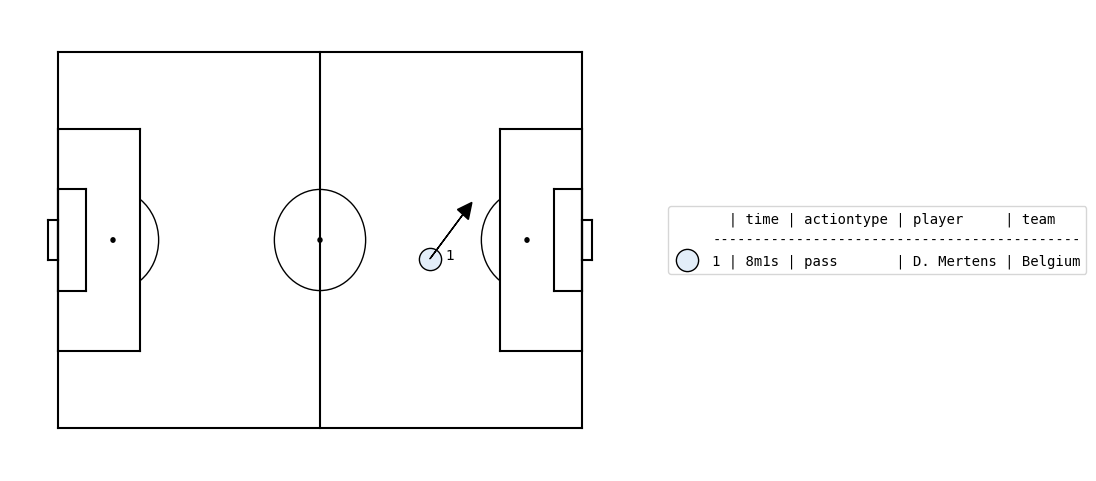

In [27]:
action_id = 145
plot_actions(df_actions[action_id:action_id+1])

In [28]:
df_actions[action_id:action_id+1].T

,145
action_id,145
game_id,2058007.0
period_id,1.0
time_seconds,481.571021
team_id,5629.0
player_id,122.0
start_x,74.55
start_y,30.6
end_x,82.95
end_y,40.8


## Representing locations

In [29]:
PITCH_LENGTH = 105
PITCH_WIDTH = 68

In [30]:
df_actions[action_id:action_id+1][['start_x', 'start_y', 'end_x', 'end_y']]

,start_x,start_y,end_x,end_y
145,74.55,30.6,82.95,40.8


The following cell adds columns to the actions dataframe with the normalized start and end coordinates of the actions.

In [31]:
for side in ['start', 'end']:
    # Normalize the X location
    key_x = f'{side}_x'
    df_actions[f'{key_x}_norm'] = df_actions[key_x] / PITCH_LENGTH

    # Normalize the Y location
    key_y = f'{side}_y'
    df_actions[f'{key_y}_norm'] = df_actions[key_y] / PITCH_WIDTH
df_actions[action_id:action_id+1][['start_x_norm', 'start_y_norm', 'end_x_norm', 'end_y_norm']]

,start_x_norm,start_y_norm,end_x_norm,end_y_norm
145,0.71,0.45,0.79,0.6


The following cells compute the polar coordinates of the start and end location of the actions.

In [32]:
GOAL_X = PITCH_LENGTH
GOAL_Y = PITCH_WIDTH / 2

for side in ['start', 'end']:
    diff_x = GOAL_X - df_actions[f'{side}_x']
    diff_y = abs(GOAL_Y - df_actions[f'{side}_y'])
    df_actions[f'{side}_distance_to_goal'] = np.sqrt(diff_x ** 2 + diff_y ** 2)
    df_actions[f'{side}_angle_to_goal'] = np.divide(diff_x, diff_y,
                                                    out=np.zeros_like(diff_x),
                                                    where=(diff_y != 0))

df_actions[action_id:action_id+1][['start_distance_to_goal', 'start_angle_to_goal', 'end_distance_to_goal', 'end_angle_to_goal']]

,start_distance_to_goal,start_angle_to_goal,end_distance_to_goal,end_angle_to_goal
145,30.639231,8.955882,23.074716,3.242647


We are trying to add some features to the dataset here, the following cell adds a column indicating whether the action starts and/or ends in the opponent penalty box.

In [33]:
for side in ['start', 'end']:
    df_actions[f'{side}_is_penalty_box'] = ((df_actions[f'{side}_x'] > (PITCH_LENGTH-16.5)) &
                                            (df_actions[f'{side}_y'] > (13.85)) &
                                            (df_actions[f'{side}_y'] > (PITCH_WIDTH-13.85)))

df_actions[action_id:action_id+1][['start_is_penalty_box', 'end_is_penalty_box']]

,start_is_penalty_box,end_is_penalty_box
145,False,False


## Representing body part, action type and result

In [34]:
pd.get_dummies(df_actions['type_name'])

,clearance,corner_crossed,corner_short,cross,dribble,foul,freekick_crossed,freekick_short,goalkick,interception,keeper_save,pass,shot,shot_freekick,tackle,take_on,throw_in
0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1388,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1389,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1390,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False


In [35]:
def add_action_type_dummies(df_actions):
    return df_actions.merge(pd.get_dummies(df_actions['type_name']), how='left',
                             left_index=True, right_index=True)

In [36]:
df_actions = add_action_type_dummies(df_actions)
df_actions[action_id:action_id+1].T

,145
action_id,145
game_id,2058007.0
period_id,1.0
time_seconds,481.571021
team_id,5629.0
player_id,122.0
start_x,74.55
start_y,30.6
end_x,82.95
end_y,40.8


In [37]:
df_actions['bodypart_name'].unique()

array(['foot', 'other', 'head'], dtype=object)

In [38]:
df_actions['result_name'].unique()

array(['success', 'fail', 'offside'], dtype=object)

In [39]:
df_actions[action_id:action_id+1][['bodypart_name', 'result_name']]

,bodypart_name,result_name
145,foot,success


## Determine distance covered in x, y and total time played

The following cells define functions that add distance features and the actual time played in the match at the moment of the action.

In [40]:
def add_distance_features(df_actions):
    df_actions['diff_x'] = df_actions['end_x'] - df_actions['start_x']
    df_actions['diff_y'] = df_actions['end_y'] - df_actions['start_y']
    df_actions['distance_covered'] = np.sqrt((df_actions['end_x'] - df_actions['start_x']) ** 2 +
                                             (df_actions['end_y'] - df_actions['start_y']) ** 2)

In [41]:
def add_time_played(df_actions):
    df_actions['time_played'] = (df_actions['time_seconds'] +
                             (df_actions['period_id'] >= 2) * (45 * 60) +
                             (df_actions['period_id'] >= 3) * (15 * 60) +
                             (df_actions['period_id'] == 4) * (15 * 60)
                             )

In [42]:
add_distance_features(df_actions)
add_time_played(df_actions)

In [43]:
df_actions[action_id:action_id+1][['diff_x', 'diff_y', 'distance_covered', 'time_played']]

,diff_x,diff_y,distance_covered,time_played
145,8.4,10.2,13.213629,481.571021


## Representing actions leading to game state

The following represents the action and what happened before and after the action was executed.

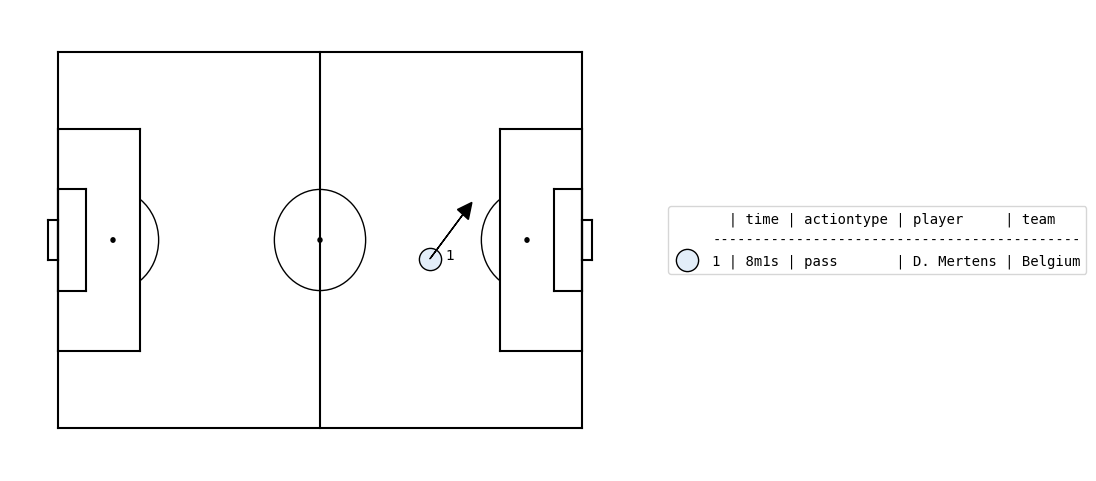

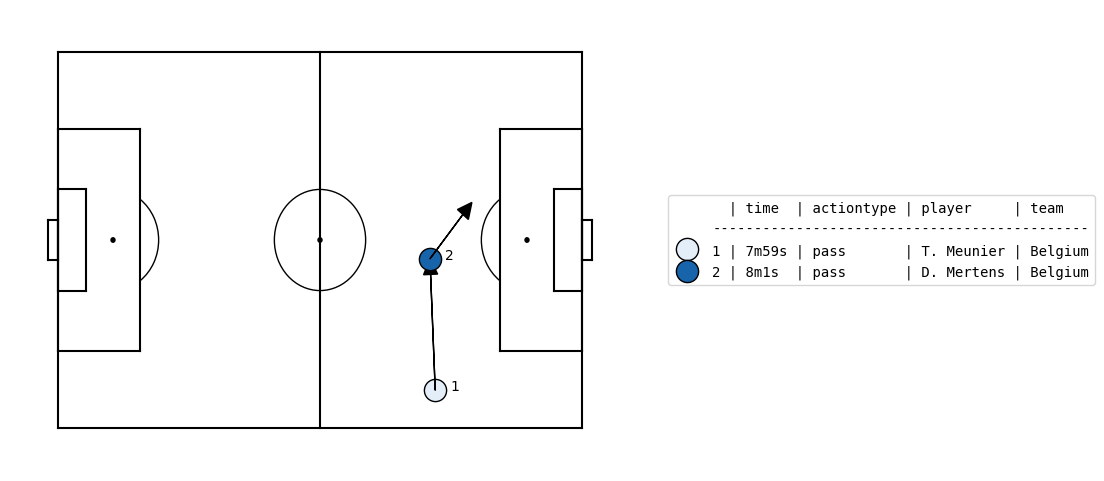

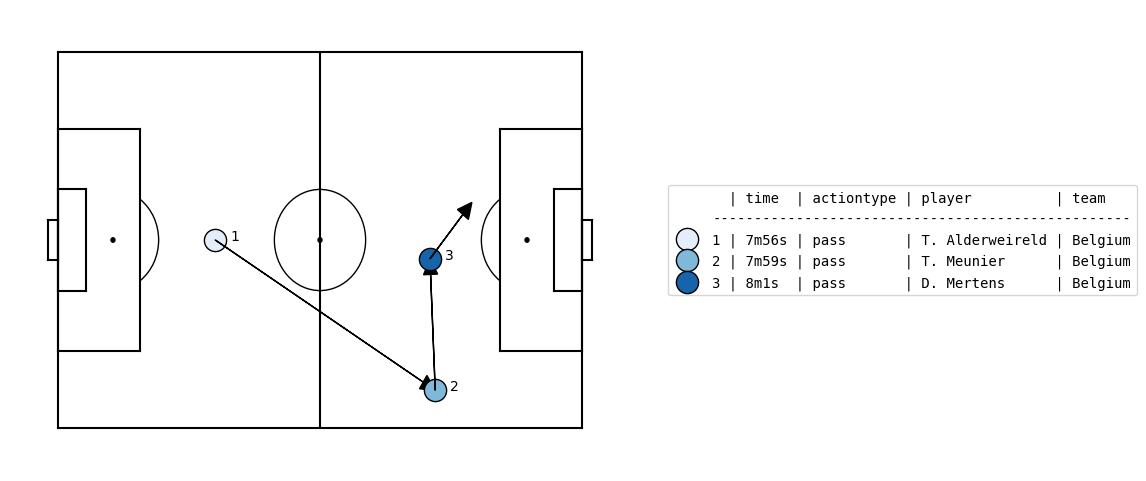

In [44]:
for i in range(3):
    df_actions_to_plot = df_actions[145-i:146]
    plot_actions(df_actions_to_plot)

The following cells add extra columns for each action on the x actions before the action itself.

In [45]:
delays = 3  # you can play around with this number
features_to_delay = ['game_id', 'period_id', 'time_seconds', 'team_id',
                     'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'bodypart_id',
                     'type_id', 'result_id', 'type_name', 'result_name', 'bodypart_name',
                     'time_played']

In [46]:
def create_delayed_features(df_actions, features_to_delay, delays):
    df_delays = [df_actions[features_to_delay].shift(step).add_suffix(f'-{step}') for step in range(0, delays)]
    return pd.concat(df_delays, axis=1)

In [47]:
df_features = create_delayed_features(df_actions, features_to_delay, delays)
location_cols = [f'{side}_{xy}-{delay}' for delay in reversed(range(0, delays))
                 for xy in ['x', 'y'] for side in ['start', 'end']]
df_features[action_id:action_id+1][location_cols]

,start_x-2,end_x-2,start_y-2,end_y-2,start_x-1,end_x-1,start_y-1,end_y-1,start_x-0,end_x-0,start_y-0,end_y-0
145,31.5,75.6,34.0,6.8,75.6,74.55,6.8,30.6,74.55,82.95,30.6,40.8


In [48]:
cols = [f'{col}-{delay}' for delay in reversed(range(0, delays))
        for col in ['period_id', 'time_seconds', 'type_name', 'bodypart_name', 'result_name']]
df_features[action_id:action_id+1][cols]

,period_id-2,time_seconds-2,type_name-2,bodypart_name-2,result_name-2,period_id-1,time_seconds-1,type_name-1,bodypart_name-1,result_name-1,period_id-0,time_seconds-0,type_name-0,bodypart_name-0,result_name-0
145,1.0,476.196484,pass,foot,success,1.0,479.134156,pass,foot,success,1.0,481.571021,pass,foot,success


We need to invert the coordinates for the actions made by the other team to make sure all features represent the same thing. Therefore we add an indicator for the delayed actions to indicate whether the action was executed by the same team or not. If not then we need to invert the coordinates as the coordinates normally always go from left to right for the team in possession.

In [49]:
def add_same_team(df_features, delays):
    for step in range(1, delays):
        df_features[f'team-{step}'] = df_features['team_id-0'] == df_features[f'team_id-{step}']

In [50]:
add_same_team(df_features, delays)

In [51]:
def invert_coordinates(df_features, delays):
    for step in range(1, delays):
        for side in ['start', 'end']:
            df_features.loc[~(df_features[f'team-{step}']), f'{side}_x-{step}'] = PITCH_LENGTH - df_features[f'{side}_x-{step}']
            df_features.loc[~(df_features[f'team-{step}']), f'{side}_y-{step}'] = PITCH_WIDTH - df_features[f'{side}_y-{step}']

df_features[location_cols+['team-1', 'team-2']].tail(10)

,start_x-2,end_x-2,start_y-2,end_y-2,start_x-1,end_x-1,start_y-1,end_y-1,start_x-0,end_x-0,start_y-0,end_y-0,team-1,team-2
1382,49.35,34.65,36.04,32.64,34.65,34.65,29.24,29.24,32.55,0.00,37.40,30.60,False,True
1383,34.65,34.65,29.24,29.24,32.55,0.00,37.40,30.60,0.00,0.00,30.60,30.60,False,True
1384,32.55,0.00,37.40,30.60,0.00,0.00,30.60,30.60,0.00,0.00,0.00,68.00,False,True
1385,0.00,0.00,30.60,30.60,0.00,0.00,0.00,68.00,13.65,30.45,29.24,22.44,False,True
1386,0.00,0.00,0.00,68.00,13.65,30.45,29.24,22.44,30.45,60.90,22.44,31.96,True,False
1387,13.65,30.45,29.24,22.44,30.45,60.90,22.44,31.96,60.90,86.10,31.96,11.56,True,True
1388,30.45,60.90,22.44,31.96,60.90,86.10,31.96,11.56,86.10,94.50,11.56,31.28,True,True
1389,60.90,86.10,31.96,11.56,86.10,94.50,11.56,31.28,94.50,95.55,31.28,39.44,True,True
1390,86.10,94.50,11.56,31.28,94.50,95.55,31.28,39.44,95.55,105.00,39.44,34.00,True,True
1391,94.50,95.55,31.28,39.44,95.55,105.00,39.44,34.00,51.45,0.00,34.00,68.00,False,False


In [52]:
invert_coordinates(df_features, delays)
df_features[location_cols+['team-1', 'team-2']].tail(10)

,start_x-2,end_x-2,start_y-2,end_y-2,start_x-1,end_x-1,start_y-1,end_y-1,start_x-0,end_x-0,start_y-0,end_y-0,team-1,team-2
1382,49.35,34.65,36.04,32.64,70.35,70.35,38.76,38.76,32.55,0.00,37.40,30.60,False,True
1383,34.65,34.65,29.24,29.24,72.45,105.00,30.60,37.40,0.00,0.00,30.60,30.60,False,True
1384,32.55,0.00,37.40,30.60,105.00,105.00,37.40,37.40,0.00,0.00,0.00,68.00,False,True
1385,0.00,0.00,30.60,30.60,105.00,105.00,68.00,0.00,13.65,30.45,29.24,22.44,False,True
1386,105.00,105.00,68.00,0.00,13.65,30.45,29.24,22.44,30.45,60.90,22.44,31.96,True,False
1387,13.65,30.45,29.24,22.44,30.45,60.90,22.44,31.96,60.90,86.10,31.96,11.56,True,True
1388,30.45,60.90,22.44,31.96,60.90,86.10,31.96,11.56,86.10,94.50,11.56,31.28,True,True
1389,60.90,86.10,31.96,11.56,86.10,94.50,11.56,31.28,94.50,95.55,31.28,39.44,True,True
1390,86.10,94.50,11.56,31.28,94.50,95.55,31.28,39.44,95.55,105.00,39.44,34.00,True,True
1391,10.50,9.45,36.72,28.56,9.45,0.00,28.56,34.00,51.45,0.00,34.00,68.00,False,False


The following cells add the location featues for all actions and their delayed actions using the right coordinates.

In [53]:
def add_location_features(df_features, delays):
    for step in range(0, delays):
        for side in ['start', 'end']:
            # Normalize the X location
            key_x = f'{side}_x'
            df_features[f'{key_x}_norm-{step}'] = df_features[f'{key_x}-{step}'] / PITCH_LENGTH

            # Normalize the Y location
            key_y = f'{side}_y'
            df_features[f'{key_y}_norm-{step}'] = df_features[f'{key_y}-{step}'] / PITCH_WIDTH

            diff_x = GOAL_X - df_features[f'{side}_x-{step}']
            diff_y = abs(GOAL_Y - df_features[f'{side}_y-{step}'])
            df_features[f'{side}_distance_to_goal-{step}'] = np.sqrt(diff_x ** 2 + diff_y ** 2)
            df_features[f'{side}_angle_to_goal-{step}'] = np.divide(diff_x, diff_y, out=np.zeros_like(diff_x), where=(diff_y != 0))

            df_features[f'diff_x-{step}'] = df_features[f'end_x-{step}'] - df_features[f'start_x-{step}']
            df_features[f'diff_y-{step}'] = df_features[f'end_y-{step}'] - df_features[f'start_y-{step}']
            df_features[f'distance_covered-{step}'] = np.sqrt((df_features[f'end_x-{step}'] - df_features[f'start_x-{step}']) ** 2 +
                                             (df_features[f'end_y-{step}'] - df_features[f'start_y-{step}']) ** 2)

In [54]:
add_location_features(df_features, delays)
df_features.head()

,game_id-0,period_id-0,time_seconds-0,team_id-0,player_id-0,start_x-0,start_y-0,end_x-0,end_y-0,bodypart_id-0,...,start_y_norm-2,start_distance_to_goal-2,start_angle_to_goal-2,diff_x-2,diff_y-2,distance_covered-2,end_x_norm-2,end_y_norm-2,end_distance_to_goal-2,end_angle_to_goal-2
0,2058007.0,1.0,2.661076,5629.0,7905.0,52.5,34.00,42.00,32.64,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2058007.0,1.0,4.460889,5629.0,70123.0,42.0,32.64,33.60,57.12,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2058007.0,1.0,7.611112,5629.0,48.0,33.6,57.12,23.10,42.16,0,...,0.50,52.500000,0.000000,-10.5,-1.36,10.587710,0.40,0.48,63.014678,46.323529
3,2058007.0,1.0,9.700278,5629.0,8307.0,23.1,42.16,25.20,20.40,0,...,0.48,63.014678,46.323529,-8.4,24.48,25.881082,0.32,0.84,75.049946,3.088235
4,2058007.0,1.0,12.723724,5629.0,36.0,25.2,20.40,13.65,40.12,0,...,0.84,75.049946,3.088235,-10.5,-14.96,18.277079,0.22,0.62,82.305502,10.036765


The following cells add more features on the sequence. The distance covered in x and y direction as well as the time passed in the action are added to the dataframe. These features tells the model about the speed of play, whether the game quickly progressed from one side to another or whether it is a slow build up play.

In [55]:
def add_sequence_pre_features(df_features, delays):
    delay = delays - 1
    df_features['xdiff_sequence_pre'] = df_features['start_x-0'] - df_features[f'start_x-{delay}']
    df_features['ydiff_sequence_pre'] = df_features['start_y-0'] - df_features[f'start_y-{delay}']
    df_features['time_sequence_pre'] = df_features['time_played-0'] - df_features[f'time_played-{delay}']

In [56]:
add_sequence_pre_features(df_features, delays)

In [57]:
def add_sequence_post_features(df_features, delays):
    delay = delays - 1
    df_features['xdiff_sequence_post'] = df_features['end_x-0'] - df_features[f'start_x-{delay}']
    df_features['ydiff_sequence_post'] = df_features['end_y-0'] - df_features[f'start_y-{delay}']

add_sequence_post_features(df_features, delays)

In [58]:
df_features[action_id:action_id+1]

,game_id-0,period_id-0,time_seconds-0,team_id-0,player_id-0,start_x-0,start_y-0,end_x-0,end_y-0,bodypart_id-0,...,distance_covered-2,end_x_norm-2,end_y_norm-2,end_distance_to_goal-2,end_angle_to_goal-2,xdiff_sequence_pre,ydiff_sequence_pre,time_sequence_pre,xdiff_sequence_post,ydiff_sequence_post
145,2058007.0,1.0,481.571021,5629.0,122.0,74.55,30.6,82.95,40.8,0,...,51.813608,0.72,0.1,40.052466,1.080882,43.05,-3.4,5.374537,51.45,6.8


# Generate features for a match

In [59]:
# The following cell defines a function that creates all features as calculated above for a dataframe of actions for a given match.

def create_features_match(df_actions, features_to_delay, delays):
    df_action_features = add_action_type_dummies(df_actions)
    add_time_played(df_action_features)
    df_gamestate_features = create_delayed_features(df_action_features, features_to_delay, delays)
    add_same_team(df_gamestate_features, delays)
    invert_coordinates(df_gamestate_features, delays)
    add_location_features(df_gamestate_features, delays)
    add_sequence_pre_features(df_gamestate_features, delays)
    add_sequence_post_features(df_gamestate_features, delays)
    return df_gamestate_features

# Generate labels for a match

The following cells define two functions that compute the labels of our two machine learning tasks. The first one tells us whether a goal was scored within x actions, whereas the second function tells us whether a goal was conceded within the next x actions.

In [60]:
def label_scores(df_actions, nr_actions):
    """
    This functiondf_actions determines whether a goal was scored by the team possessing
    the ball within the next x actions
    """
    # merging goals, owngoals and team_ids

    goals = df_actions['type_name'].str.contains('shot') & (
        df_actions['result_id'] == 1
    )
    owngoals = df_actions['type_name'].str.contains('shot') & (
        df_actions['result_id'] == 2
    )
    y = pd.concat([goals, owngoals, df_actions['team_id']], axis=1)
    y.columns = ['goal', 'owngoal', 'team_id']

    # adding future results
    for i in range(1, nr_actions):
        for col in ['team_id', 'goal', 'owngoal']:
            shifted = y[col].shift(-i)
            shifted[-i:] = y[col][len(y) - 1]
            y[f'{col}+{i}'] = shifted

    scores = y['goal']
    for i in range(1, nr_actions):
        goal_scored = y[f'goal+{i}'] & (y[f'team_id+{i}'] == y['team_id'])
        own_goal_opponent = y[f'owngoal+{i}'] & (y[f'team_id+{i}'] != y['team_id'])
        scores = scores | goal_scored | own_goal_opponent

    return pd.DataFrame(scores, columns=['scores'])

In [61]:
def label_concedes(df_actions, nr_actions):
    """
    This function determines whether a goal was scored by the team not
    possessing the ball within the next x actions
    """
    # merging goals,owngoals and team_ids
    goals = df_actions['type_name'].str.contains('shot') & (
        df_actions['result_id'] == 1
    )
    owngoals = df_actions['type_name'].str.contains('shot') & (
        df_actions['result_id'] == 2
    )
    y = pd.concat([goals, owngoals, df_actions['team_id']], axis=1)
    y.columns = ['goal', 'owngoal', 'team_id']

    # adding future results
    for i in range(1, nr_actions):
        for col in ['team_id', 'goal', 'owngoal']:
            shifted = y[col].shift(-i)
            shifted[-i:] = y[col][len(y) - 1]
            y[f'{col}+{i}'] = shifted

    concedes = y['owngoal']
    for i in range(1, nr_actions):
        goal_opponent = y[f'goal+{i}'] & (y[f'team_id+{i}'] != y['team_id'])
        own_goal_team = y[f'owngoal+{i}'] & (y[f'team_id+{i}'] == y['team_id'])
        concedes = concedes | goal_opponent | own_goal_team

    return pd.DataFrame(concedes, columns=['concedes'])

We compute the labels for the match and investigate the labels for the last ten actions in the match.

In [62]:
df_labels = pd.concat([label_scores(df_actions, nr_actions=10),
                           label_concedes(df_actions, nr_actions=10)],
                          axis=1)

df_labels.tail(10)

,scores,concedes
1382,False,True
1383,True,False
1384,False,True
1385,True,False
1386,True,False
1387,True,False
1388,True,False
1389,True,False
1390,True,False
1391,False,False


# Save features and labels for all matches

The following cells generate and store the features and labels for all matches in spadl.h5 file.

In [63]:
df_games = pd.read_hdf('spadl.h5', key='games')

In [64]:
df_games.head()

,game_id,competition_id,season_id,game_date,home_team_id,away_team_id
0,2565922,795,181144,2018-05-20 18:45:00,676,687
1,2565925,795,181144,2018-05-20 16:30:00,679,701
2,2565919,795,181144,2018-05-20 14:15:00,678,691
3,2565924,795,181144,2018-05-20 10:00:00,674,677
4,2565927,795,181144,2018-05-19 18:45:00,682,675


In [65]:
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    with pd.HDFStore('spadl.h5') as spadlstore:
        df_actions = spadlstore[f'actions/game_{game_id}']
        df_actions = (
            df_actions.merge(spadlstore['actiontypes'], how='left')
            .merge(spadlstore['results'], how='left')
            .merge(spadlstore['bodyparts'], how='left')
            .reset_index(drop=True)
        )

    df_features = create_features_match(df_actions, features_to_delay, delays)
    df_features.to_hdf('features.h5', f'game_{game_id}')

    df_labels = pd.concat([label_scores(df_actions, nr_actions=10),
                           label_concedes(df_actions, nr_actions=10)],
                          axis=1)
    df_labels.to_hdf('labels.h5', f'game_{game_id}')

  0%|          | 0/495 [00:00<?, ?it/s]

# Training ML Model

In [66]:
df_games = pd.read_hdf('spadl.h5', key='games')
df_games.tail(10)

,game_id,competition_id,season_id,game_date,home_team_id,away_team_id
54,2057984,28,10078,2018-06-17 15:00:00,3148,15473
55,2057979,28,10078,2018-06-17 12:00:00,16871,17322
56,2057973,28,10078,2018-06-16 19:00:00,9598,16823
57,2057967,28,10078,2018-06-16 16:00:00,15594,7712
58,2057972,28,10078,2018-06-16 13:00:00,12274,7839
59,2057966,28,10078,2018-06-16 10:00:00,4418,8493
60,2057960,28,10078,2018-06-15 18:00:00,9905,1598
61,2057961,28,10078,2018-06-15 15:00:00,16216,10840
62,2057955,28,10078,2018-06-15 12:00:00,16129,15670
63,2057954,28,10078,2018-06-14 15:00:00,14358,16521


In [67]:
dfs_features = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_features = pd.read_hdf('features.h5', key=f'game_{game_id}')
    df_features['game_id'] = game_id
    dfs_features.append(df_features)
df_features = pd.concat(dfs_features).reset_index(drop=True)

  0%|          | 0/495 [00:00<?, ?it/s]

In [68]:
df_features.tail(10)

,game_id-0,period_id-0,time_seconds-0,team_id-0,player_id-0,start_x-0,start_y-0,end_x-0,end_y-0,bodypart_id-0,...,end_x_norm-2,end_y_norm-2,end_distance_to_goal-2,end_angle_to_goal-2,xdiff_sequence_pre,ydiff_sequence_pre,time_sequence_pre,xdiff_sequence_post,ydiff_sequence_post,game_id
618541,2057954.0,2.0,2860.543201,14358.0,102157.0,58.80,41.48,58.80,38.08,0,...,0.64,0.44,38.019553,9.264706,4.20,14.28,5.269374,4.20,10.88,2057954
618542,2057954.0,2.0,2861.719049,14358.0,102157.0,58.80,38.08,69.30,45.56,0,...,0.56,0.61,46.801607,6.176471,-8.40,8.16,4.900802,2.10,15.64,2057954
618543,2057954.0,2.0,2863.131899,14358.0,4513.0,69.30,45.56,55.65,42.16,0,...,0.56,0.56,46.379806,11.323529,10.50,4.08,2.588698,-3.15,0.68,2057954
618544,2057954.0,2.0,2864.548384,14358.0,220971.0,55.65,42.16,72.45,24.48,0,...,0.66,0.67,37.524973,3.088235,-3.15,4.08,2.829335,13.65,-13.60,2057954
618545,2057954.0,2.0,2865.964868,14358.0,220971.0,72.45,24.48,76.65,19.04,0,...,0.53,0.62,50.020077,6.047794,3.15,-21.08,2.832969,7.35,-26.52,2057954
618546,2057954.0,2.0,2868.496551,14358.0,103682.0,76.65,19.04,81.90,20.40,0,...,0.69,0.36,33.913609,3.419118,21.00,-23.12,3.948167,26.25,-21.76,2057954
618547,2057954.0,2.0,2870.980334,16521.0,122577.0,81.90,20.40,80.85,25.16,0,...,0.27,0.72,78.096249,5.123663,49.35,-23.12,5.015466,48.30,-18.36,2057954
618548,2057954.0,2.0,2872.843120,16521.0,122577.0,80.85,25.16,80.85,25.16,0,...,0.22,0.70,83.021503,6.022059,52.50,-23.80,4.346569,52.50,-23.80,2057954
618549,2057954.0,2.0,2939.438099,14358.0,257800.0,85.05,22.44,105.00,30.60,0,...,0.23,0.63,81.331839,9.145928,61.95,-25.16,68.457765,81.90,-17.00,2057954
618550,2057954.0,2.0,2983.382036,16521.0,122623.0,52.50,34.00,0.00,68.00,0,...,0.77,0.37,25.717078,2.731900,-28.35,8.84,110.538916,-80.85,42.84,2057954


In [69]:
dfs_labels = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_labels = pd.read_hdf('labels.h5', key=f'game_{game_id}')
    df_labels['game_id'] = game_id
    dfs_labels.append(df_labels)
df_labels = pd.concat(dfs_labels).reset_index(drop=True)

  0%|          | 0/495 [00:00<?, ?it/s]

In [70]:
df_labels.tail(10)

,scores,concedes,game_id
618541,True,False,2057954
618542,True,False,2057954
618543,True,False,2057954
618544,True,False,2057954
618545,True,False,2057954
618546,True,False,2057954
618547,False,True,2057954
618548,False,True,2057954
618549,True,False,2057954
618550,False,False,2057954


# Split dataset

In [71]:
!pip install scikit-plot

In [72]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scikitplot.metrics import plot_calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from xgboost import XGBClassifier

In [73]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(
    df_features,
    df_labels,
    test_size=0.10,
    random_state=42,
    stratify=df_labels['scores'].astype(str) + '_' + df_labels['concedes'].astype(str)
)

Finding mean values of features

In [74]:
df_y_train['scores'].mean()

0.015487834451539891

In [75]:
df_y_test['scores'].mean()

0.015487584066218314

In [76]:
df_y_train['concedes'].mean()

0.005205723061999838

In [77]:
df_y_test['concedes'].mean()

0.005205638903259183

# Baseline classifiers

The following cell provides a list of features that the machine learning algorithm will consider to train the model.

In [78]:
features = [
    'start_distance_to_goal-0',
    'end_distance_to_goal-0',
    'start_distance_to_goal-1',
    'end_distance_to_goal-1',
    'start_distance_to_goal-2',
    'end_distance_to_goal-2',
    'start_angle_to_goal-0',
    'end_angle_to_goal-0',
    'start_angle_to_goal-1',
    'end_angle_to_goal-1',
    'start_angle_to_goal-2',
    'end_angle_to_goal-2',
    'team-1',
    'team-2'
]

The following cell provides a list of class labels for which the machine learning algorithm will train a model.

In [79]:
labels = [
    'scores',
     'concedes'
]

## Train classifiers

### XGBoost Classifier

In [80]:
!pip install xgboost
import xgboost

In [81]:
%%time
models = {}
for label in tqdm(labels):
    model = XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False,
        n_estimators=10,
        max_depth=3
    )
    model.fit(
        X=df_X_train[features],
        y=df_y_train[label]
    )
    models[label] = model

  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 10.3 s, sys: 577 ms, total: 10.9 s
Wall time: 19.4 s


In [82]:
from sklearn.metrics import accuracy_score
y_pred_poly = model.predict(df_X_test[features])
accuracy_XGB = accuracy_score(df_y_test[label], y_pred_poly)
print(f"XGBoost Accuracy: {accuracy_XGB:.2f}")

XGBoost Accuracy: 0.99


### Random Forest Classifier

In [83]:
'''from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, accuracy_score

df_X_train[features] = df_X_train[features].fillna(0)
df_X_test[features] = df_X_test[features].fillna(0)

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(df_X_train[features], df_y_train[label])
y_pred_poly = clf.predict(df_X_test[features])
accuracy_rf = (accuracy_score(df_y_test[label], y_pred_poly))
print(f"RandomForest Accuracy: {accuracy_rf:.2f}-")'''

'from sklearn.ensemble import RandomForestClassifier\nfrom sklearn.datasets import make_classification\nfrom sklearn.metrics import classification_report, accuracy_score\n\ndf_X_train[features] = df_X_train[features].fillna(0)\ndf_X_test[features] = df_X_test[features].fillna(0)\n\nclf = RandomForestClassifier(max_depth=2, random_state=0)\nclf.fit(df_X_train[features], df_y_train[label])\ny_pred_poly = clf.predict(df_X_test[features])\naccuracy_rf = (accuracy_score(df_y_test[label], y_pred_poly))\nprint(f"RandomForest Accuracy: {accuracy_rf:.2f}-")'

### Polynomial Classifier

In [84]:
'''from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score

poly = PolynomialFeatures(degree=2)

clf = MultinomialNB()
clf.fit(df_X_train[features], df_y_train[label])
y_pred_poly = clf.predict(df_X_test[features])
accuracy_scoreMNB = accuracy_score(df_y_test[label], y_pred_poly)
print(f"Polynomial NB Accuracy: {accuracy_scoreMNB:.2f}")'''

'from sklearn.naive_bayes import MultinomialNB\nfrom sklearn.preprocessing import PolynomialFeatures\nfrom sklearn.metrics import accuracy_score\n\npoly = PolynomialFeatures(degree=2)\n\nclf = MultinomialNB()\nclf.fit(df_X_train[features], df_y_train[label])\ny_pred_poly = clf.predict(df_X_test[features])\naccuracy_scoreMNB = accuracy_score(df_y_test[label], y_pred_poly)\nprint(f"Polynomial NB Accuracy: {accuracy_scoreMNB:.2f}")'

### Bagging Classifier

In [85]:
'''from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, accuracy_score

clf = DecisionTreeClassifier(random_state=42)
bagging_clf = BaggingClassifier(base_estimator=clf, n_estimators=10, random_state=42)
bagging_clf.fit(df_X_train[features], df_y_train[label])
y_pred = bagging_clf.predict(df_X_test[features])

accuracy_scorebt = accuracy_score(df_y_test[label], y_pred_poly)
print(f"Bagging classifier: {accuracy_scorebt:.2f}")'''

'from sklearn.tree import DecisionTreeClassifier\nfrom sklearn.ensemble import BaggingClassifier\nfrom sklearn.metrics import classification_report, accuracy_score\n\nclf = DecisionTreeClassifier(random_state=42)\nbagging_clf = BaggingClassifier(base_estimator=clf, n_estimators=10, random_state=42)\nbagging_clf.fit(df_X_train[features], df_y_train[label])\ny_pred = bagging_clf.predict(df_X_test[features])\n\naccuracy_scorebt = accuracy_score(df_y_test[label], y_pred_poly)\nprint(f"Bagging classifier: {accuracy_scorebt:.2f}")'

In [86]:
'''import matplotlib.pyplot as plt
import numpy as np

# Create data
labels = ['XGBoost', 'Random Forest', 'Polynomial NB', 'Bagging']
accuracy = [accuracy_XGB, accuracy_rf, accuracy_scoreMNB, accuracy_scorebt]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accuracy, width, label='Accuracy')

# Add x-axis labels
ax.set_xticks(x)
ax.set_xticklabels(labels)
# Add labels, title, and grid
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison of Different Classifiers')
ax.legend()
plt.tight_layout()
plt.show()'''

"import matplotlib.pyplot as plt\nimport numpy as np\n\n# Create data\nlabels = ['XGBoost', 'Random Forest', 'Polynomial NB', 'Bagging']\naccuracy = [accuracy_XGB, accuracy_rf, accuracy_scoreMNB, accuracy_scorebt]\n\nx = np.arange(len(labels))  # the label locations\nwidth = 0.35  # the width of the bars\n\nfig, ax = plt.subplots()\nrects1 = ax.bar(x - width/2, accuracy, width, label='Accuracy')\n\n# Add x-axis labels\nax.set_xticks(x)\nax.set_xticklabels(labels)\n# Add labels, title, and grid\nax.set_ylabel('Accuracy')\nax.set_title('Accuracy Comparison of Different Classifiers')\nax.legend()\nplt.tight_layout()\nplt.show()"

## Estimate probabilities

The following cell estimates the probabilities for each label using the trained *baseline* models.

In [87]:
dfs_predictions = {}
for label in tqdm(labels):
    model = models[label]
    probabilities = model.predict_proba(
        df_X_test[features]
    )
    predictions = probabilities[:, 1]
    dfs_predictions[label] = pd.Series(predictions, index=df_X_test.index)
df_predictions = pd.concat(dfs_predictions, axis=1)

  0%|          | 0/2 [00:00<?, ?it/s]

In [88]:
df_predictions.head(10)

,scores,concedes
116871,0.015002,0.008990
189362,0.015195,0.008707
111940,0.018929,0.008707
392335,0.050173,0.025095
305171,0.015195,0.008707
397716,0.021432,0.008707
277721,0.015002,0.008990
458543,0.015002,0.008990
198065,0.015002,0.008990
190851,0.015606,0.011094


## Evaluate probabilities

### Compute base rate probabilities

The following cell computes the *base rate* or *prior probability* of each class label in the training set. We use the *base rate* as a naive estimate for each example in the test set being true to establish a baseline for the evaluation metrics.

In [89]:
df_base_rates = pd.DataFrame({
    label:np.full(len(df_y_test[label]), df_y_train[label].mean()) for label in labels
})
df_base_rates.head(10)

,scores,concedes
0,0.015488,0.005206
1,0.015488,0.005206
2,0.015488,0.005206
3,0.015488,0.005206
4,0.015488,0.005206
5,0.015488,0.005206
6,0.015488,0.005206
7,0.015488,0.005206
8,0.015488,0.005206
9,0.015488,0.005206


### Compute Brier score loss for goal scored model

The Brier Score is a strictly proper score function or strictly proper scoring rule that measures the accuracy of probabilistic predictions. The lesser the better for this metrics. It is only metrics which specifically suits our needs


The following cell computes the Brier loss score for the base rate predictions.

In [90]:
brier_score_loss(
    y_true=df_y_test['scores'],
    y_prob=df_base_rates['scores']
)

0.015247718806072823

The following cell computes the [Brier loss score](https://en.wikipedia.org/wiki/Brier_score) for the predictions by the learned model.

In [91]:
brier_score_loss(
    y_true=df_y_test['scores'],
    y_prob=df_predictions['scores']
)

0.014745331859525762

# Optimize classifiers

In order to train *accurate* models, we perform a *grid search* over different combinations of parameter values for the most important hyperparameters for the learning algorithm. We will focus on the number of estimators and the maximum depth of the decision trees although more hyperparameters influence the performance of the trained models. The more combinations of parameter values need to be explored, the longer the *grid search* will take.


## Train classifiers

The following cell trains an XGBoost classifier for each label by trying different combinations of hyperparameters.

In [92]:
%%time
models_cv = {}
for label in tqdm(labels):
    model = GridSearchCV(
        estimator=XGBClassifier(
            eval_metric='logloss',
            use_label_encoder=False,
        ),
        param_grid={
            'n_estimators': [50, 100],
            'max_depth': [3, 4]
        },
        scoring='neg_brier_score',
        refit=True,  # train final model on full training set using best hyperparameters
        verbose=10,
        n_jobs=1
    )
    model.fit(
        X=df_X_train[features],
        y=df_y_train[label]
    )
    models_cv[label] = model

  0%|          | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 1/5; 1/4] END max_depth=3, n_estimators=50;, score=-0.014 total time=  21.8s
[CV 2/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 2/5; 1/4] END max_depth=3, n_estimators=50;, score=-0.014 total time=  23.9s
[CV 3/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 3/5; 1/4] END max_depth=3, n_estimators=50;, score=-0.014 total time=  22.5s
[CV 4/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 4/5; 1/4] END max_depth=3, n_estimators=50;, score=-0.014 total time=  17.4s
[CV 5/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 5/5; 1/4] END max_depth=3, n_estimators=50;, score=-0.014 total time=   9.5s
[CV 1/5; 2/4] START max_depth=3, n_estimators=100...............................
[CV 1/5; 2/4] END max_depth=3, n_estimators=100;,

## Estimate probabilities

In [93]:
dfs_predictions_cv = {}
for label in tqdm(labels):
    model = models_cv[label]
    probabilities = model.predict_proba(
        df_X_test[features]
    )
    predictions = probabilities[:, 1]
    dfs_predictions_cv[label] = pd.Series(predictions, index=df_X_test.index)
df_predictions_cv = pd.concat(dfs_predictions, axis=1)

  0%|          | 0/2 [00:00<?, ?it/s]

## Evaluate probabilities

### Compute Brier score loss for goal scored model


The following cell computes the Brier loss score for the base rate predictions.

In [94]:
brier_score_loss(
    y_true=df_y_test['scores'],
    y_prob=df_base_rates['scores']
)

0.015247718806072823

The following cell computes the Brier loss score for the predictions by the learned model.

In [95]:
brier_score_loss(
    y_true=df_y_test['scores'],
    y_prob=df_predictions_cv['scores']
)

0.014745331859525762

# Construct final classifiers & optimizing the hyperparameters

Once we have found the *best* feature set and *best* hyperparameters for the learning algorithm, we can learn the final model.

1. If we use `GridSearchCV` and the `refit` parameter was set to `True`, we can retrieve the *final* model, which has been re-trained on the entire training set, by accessing the `best_estimator_` attribute of the object.
2. We can manually train the *final* model by creating a `XGBClassifier` object using the *best* hyperparameters and calling the `fit` method with the entire training set.

In [96]:
model_scores = models_cv['scores']

The following cell shows the *best* hyperparameter combination that was found using the *grid search*.

In [97]:
pd.Series(
    model_scores.best_params_
)

max_depth        4
n_estimators    50
dtype: int64

The following cell shows the full results of the *grid search*.

In [98]:
pd.DataFrame(
    model_scores.cv_results_
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,18.275799,4.962304,0.736067,0.503257,3,50,"{'max_depth': 3, 'n_estimators': 50}",-0.014430,-0.014321,-0.014193,-0.014250,-0.014279,-0.014294,0.000079,4
1,12.581961,6.777118,0.432037,0.092981,3,100,"{'max_depth': 3, 'n_estimators': 100}",-0.014396,-0.014276,-0.014160,-0.014169,-0.014226,-0.014245,0.000086,3
2,15.423537,5.736053,0.375023,0.082584,4,50,"{'max_depth': 4, 'n_estimators': 50}",-0.014380,-0.014266,-0.014133,-0.014202,-0.014189,-0.014234,0.000084,1
3,15.083815,8.500434,0.415472,0.154972,4,100,"{'max_depth': 4, 'n_estimators': 100}",-0.014398,-0.014278,-0.014148,-0.014197,-0.014192,-0.014243,0.000088,2


The following cell shows the hyperparameters that were used to re-train the model on the entire training set.

In [99]:
pd.Series(
    model_scores.best_estimator_.get_params()
)

objective                  binary:logistic
base_score                            None
booster                               None
callbacks                             None
colsample_bylevel                     None
colsample_bynode                      None
colsample_bytree                      None
device                                None
early_stopping_rounds                 None
enable_categorical                   False
eval_metric                        logloss
feature_types                         None
gamma                                 None
grow_policy                           None
importance_type                       None
interaction_constraints               None
learning_rate                         None
max_bin                               None
max_cat_threshold                     None
max_cat_to_onehot                     None
max_delta_step                        None
max_depth                                4
max_leaves                            None
min_child_w

The following cell retrieves the final `XGBClassifier` object from the `GridSearchCV` object.

In [100]:
model_scores_final = model_scores.best_estimator_
model_scores_final

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## Training the classifier using optimal hyperparameters

The following cell constructs a new `XGBoostClassifier` object using the *best* hyperparameters that were found by the *grid search*.

In [101]:
model_scores_final = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=4
)

In [102]:
model_scores_final.fit(
    X=df_X_train[features],
    y=df_y_train[label]
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

# Analyze models and results with VAEP Framework

This includes the following three steps:
   1. Analyze feature importances of the model.
   2. Analyze single predictions for game states.
   3. Analyze the player ratings that can be calculated using the two models.

In [103]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 5.5 MB/s eta 0:00:00


In [104]:
import warnings

import matplotlib.pyplot as plt
import shap
from ipywidgets import fixed, interact_manual, widgets
from socceraction.vaep.formula import value
from tqdm import tqdm
from xgboost import XGBClassifier, plot_importance

In [105]:
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)
%matplotlib inline

## Representing Feature Importance for model predictions

100%|██████████| 2/2 [00:29<00:00, 14.84s/it]


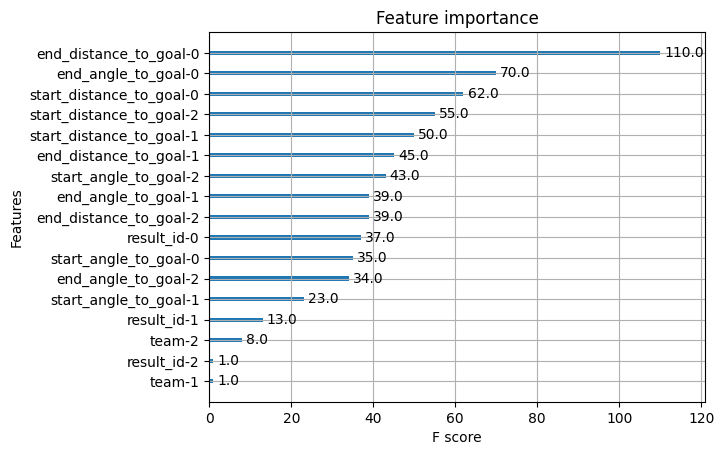

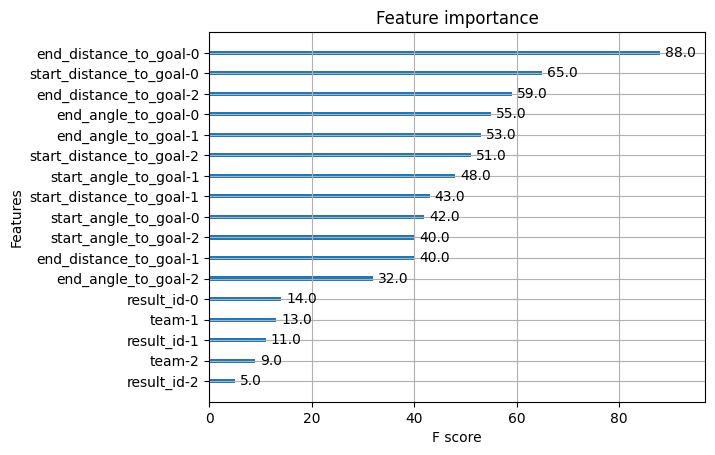

In [106]:
df_games = pd.read_hdf('spadl.h5', key='games')

# We are removing the competition_id = 795, to use the trained models to rate actions for all actions.
df_games_train = df_games[
    df_games['competition_id'] != 795
]

# We are assigning the competition_id = 795, to use the trained models to test the actions.
df_games_test = df_games[
    df_games['competition_id'] == 795
]

# Loading Features
dfs_features = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_features = pd.read_hdf('features.h5', key=f'game_{game_id}')
    df_features['game_id'] = game_id
    dfs_features.append(df_features)
df_features = pd.concat(dfs_features).reset_index(drop=True)

# Loading Labels
dfs_labels = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_labels = pd.read_hdf('labels.h5', key=f'game_{game_id}')
    df_labels['game_id'] = game_id
    dfs_labels.append(df_labels)
df_labels = pd.concat(dfs_labels).reset_index(drop=True)

# Training and testing data spilting
df_X_train = df_features[df_features['game_id'].isin(df_games_train['game_id'].unique())]
df_X_test = df_features[df_features['game_id'].isin(df_games_test['game_id'].unique())]
df_y_train = df_labels[df_labels['game_id'].isin(df_games_train['game_id'].unique())]
df_y_test = df_labels[df_labels['game_id'].isin(df_games_test['game_id'].unique())]

# Features list
features = [
    'start_distance_to_goal-0',
    'end_distance_to_goal-0',
    'start_distance_to_goal-1',
    'end_distance_to_goal-1',
    'start_distance_to_goal-2',
    'end_distance_to_goal-2',
    'start_angle_to_goal-0',
    'end_angle_to_goal-0',
    'start_angle_to_goal-1',
    'end_angle_to_goal-1',
    'start_angle_to_goal-2',
    'end_angle_to_goal-2',
    'team-1',
    'team-2',
    'result_id-0',
    'result_id-1',
    'result_id-2'
]

# Labels list
labels = ['scores', 'concedes']

#Training the final model with best hyperparameters estimated earlier
models = {}
for label in tqdm(labels):
    model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, n_estimators=100, max_depth=3)
    model.fit(X=df_X_train[features], y=df_y_train[label])
    models[label] = model

#Plotting Feature Importance for predictions
for label in labels:
    plot_importance(models[label])

## Investigate SHAP values

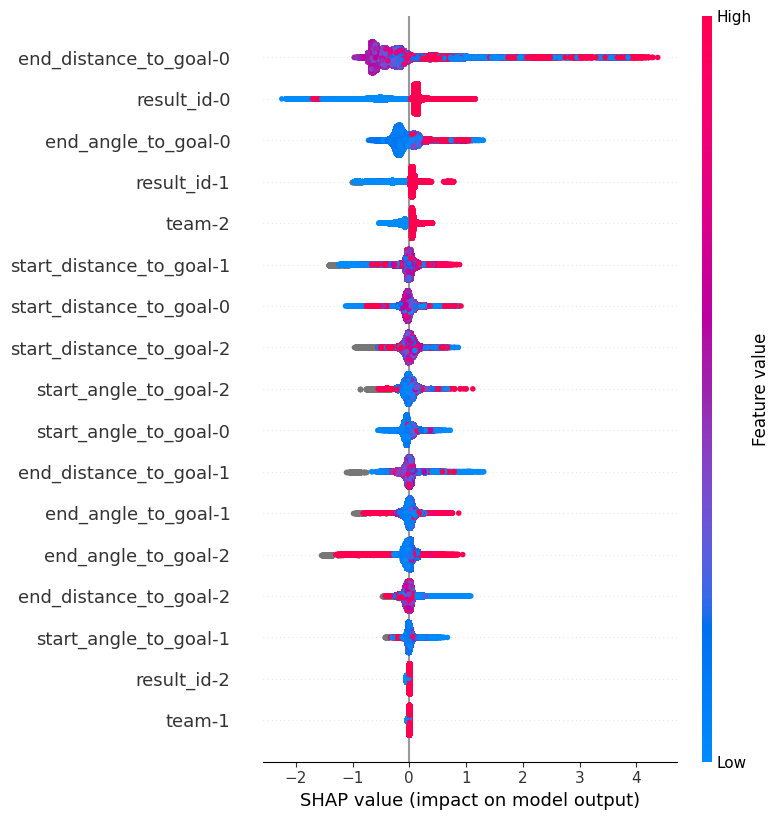

In [107]:
label='scores'
# label='concedes'

explainer = shap.TreeExplainer(models[label])

shap_values = explainer.shap_values(df_X_test[features])
shap.summary_plot(shap_values, df_X_test[features])

## Estimate probabilities

The following cell estimates the probabilities for the game states in the test set for each label using the trained models.

In [108]:
dfs_predictions = {}
for label in tqdm(labels):
    model = models[label]
    probabilities = model.predict_proba(
        df_X_test[features]
    )
    predictions = probabilities[:, 1]
    dfs_predictions[label] = pd.Series(predictions, index=df_X_test.index)
df_predictions = pd.concat(dfs_predictions, axis=1).reset_index(drop=True)
df_predictions.tail(10)

100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


,scores,concedes
474865,0.011948,0.003982
474866,0.013580,0.005991
474867,0.009158,0.004437
474868,0.014510,0.004531
474869,0.024253,0.006708
474870,0.013708,0.003788
474871,0.062418,0.001806
474872,0.011709,0.000920
474873,0.012418,0.002233
474874,0.009294,0.082495


## Load actions, players and teams and value actions

In [109]:
df_players = pd.read_hdf('spadl.h5', key='players')
df_teams = pd.read_hdf('spadl.h5', key='teams')

In [110]:
dfs_actions = []
for _, game in tqdm(df_games_test.iterrows(), total=len(df_games_test)):
    game_id = game['game_id']
    with pd.HDFStore('spadl.h5') as spadlstore:
        df_actions = spadlstore[f'actions/game_{game_id}']
        df_actions = (
            df_actions.merge(spadlstore['actiontypes'], how='left')
            .merge(spadlstore['results'], how='left')
            .merge(spadlstore['bodyparts'], how='left')
            .merge(spadlstore['players'], how='left')
            .merge(spadlstore['teams'], how='left')
            .reset_index()
            .rename(columns={'index': 'action_id'})
        )

    dfs_actions.append(df_actions)
df_actions = pd.concat(dfs_actions).reset_index(drop=True)

100%|██████████| 380/380 [01:02<00:00,  6.10it/s]


In [111]:
df_actions_predictions = pd.concat([df_actions, df_predictions], axis=1)

In [112]:
dfs_values = []
for game_id, game_predictions in df_actions_predictions.groupby('game_id'):
    df_values = value(game_predictions, game_predictions['scores'], game_predictions['concedes'])

    df_all = pd.concat([game_predictions, df_values], axis=1)
    dfs_values.append(df_all)

In [113]:
df_values = (pd.concat(dfs_values)
    .sort_values(['game_id', 'period_id', 'time_seconds'])
    .reset_index(drop=True)
)

In [114]:
df_values.tail(10)

,action_id,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,first_name,last_name,birth_date,short_team_name,team_name,scores,concedes,offensive_value,defensive_value,vaep_value
474865,1482,2565927.0,2.0,2917.139970,675.0,3309.0,46.20,62.56,8.40,48.28,...,Raphaël,Varane,1993-04-25,Real Madrid,Real Madrid Club de Fútbol,0.007309,0.006054,0.007309,-0.006054,0.001255
474866,1483,2565927.0,2.0,2925.547631,682.0,3486.0,8.40,48.28,14.70,55.08,...,Andrés Eduardo,Fernández Moreno,1986-12-17,Villarreal,Villarreal Club de Fútbol,0.009960,0.005041,0.003906,0.002268,0.006173
474867,1484,2565927.0,2.0,2928.665268,682.0,3695.0,14.70,55.08,37.80,44.88,...,Álvaro,González Soberón,1990-01-08,Villarreal,Villarreal Club de Fútbol,0.006214,0.003167,-0.003746,0.001874,-0.001871
474868,1485,2565927.0,2.0,2931.782904,682.0,3695.0,37.80,44.88,47.25,32.64,...,Álvaro,González Soberón,1990-01-08,Villarreal,Villarreal Club de Fútbol,0.026713,0.001589,0.020499,0.001577,0.022076
474869,1486,2565927.0,2.0,2932.188168,682.0,20623.0,47.25,32.64,69.30,51.00,...,Roberto,Soriano,1991-02-08,Villarreal,Villarreal Club de Fútbol,0.012670,0.001287,-0.014043,0.000303,-0.013741
474870,1487,2565927.0,2.0,2939.077491,682.0,20623.0,69.30,51.00,92.40,66.64,...,Roberto,Soriano,1991-02-08,Villarreal,Villarreal Club de Fútbol,0.033272,0.001054,0.020602,0.000233,0.020835
474871,1488,2565927.0,2.0,2940.515560,682.0,122832.0,92.40,66.64,101.85,53.72,...,Salem Mohammed,Al Dawsari,1991-08-19,Villarreal,Villarreal Club de Fútbol,0.025573,0.000731,-0.007700,0.000323,-0.007376
474872,1489,2565927.0,2.0,2942.098761,682.0,122832.0,101.85,53.72,96.60,50.32,...,Salem Mohammed,Al Dawsari,1991-08-19,Villarreal,Villarreal Club de Fútbol,0.012113,0.001283,-0.013459,-0.000553,-0.014012
474873,1490,2565927.0,2.0,2943.089232,675.0,40756.0,96.60,50.32,95.55,38.08,...,Carlos Henrique,Casimiro,1992-02-23,Real Madrid,Real Madrid Club de Fútbol,0.006185,0.019060,0.004902,-0.006947,-0.002045
474874,1491,2565927.0,2.0,2943.668846,675.0,3306.0,95.55,38.08,95.55,38.08,...,Sergio,Ramos García,1986-03-30,Real Madrid,Real Madrid Club de Fútbol,0.020796,0.005797,0.014611,0.013263,0.027874


# Rate players using VAEP framework

We investigate the ratings per player and look at the quantity-quality trade-off, risk-reward trade-off and the rating per player per action type (e.g. shot, pass, tackle, etc.)

In [115]:
df_ranking = (df_values[['player_id', 'team_name', 'short_name', 'vaep_value']]
    .groupby(['player_id', 'team_name', 'short_name'])
    .agg(vaep_count=('vaep_value', 'count'),
         vaep_mean=('vaep_value', 'mean'),
         vaep_sum=('vaep_value', 'sum'))
    .sort_values('vaep_sum', ascending=False)
    .reset_index()
)

In [116]:
df_ranking.head(10)

,player_id,team_name,short_name,vaep_count,vaep_mean,vaep_sum
0,3359.0,FC Barcelona,L. Messi,2753,0.011775,32.416279
1,7972.0,FC Barcelona,L. Suárez,1549,0.012427,19.249691
2,3840.0,Real Club Celta de Vigo,Iago Aspas,1771,0.009946,17.613704
3,395636.0,Real Club Celta de Vigo,Maxi Gómez,949,0.017695,16.792139
4,3682.0,Club Atlético de Madrid,A. Griezmann,1394,0.011543,16.091037
5,70129.0,Valencia Club de Fútbol,Rodrigo,1334,0.011764,15.693179
6,3322.0,Real Madrid Club de Fútbol,Cristiano Ronaldo,1182,0.013226,15.632824
7,3676.0,Real Sociedad de Fútbol,Illarramendi,3172,0.004741,15.039259
8,3714.0,Girona FC,C. Stuani,731,0.018732,13.693106
9,3287.0,Girona FC,Portu,1169,0.011252,13.153665


In [117]:
df_player_games = pd.read_hdf('spadl.h5', 'player_games')
df_player_games = df_player_games[df_player_games['game_id'].isin(df_games['game_id'])]

In [118]:
df_minutes_played = (df_player_games[['player_id', 'minutes_played']]
    .groupby('player_id')
    .sum()
    .reset_index()
)

In [119]:
df_minutes_played.head()

,player_id,minutes_played
0,12,186.155078
1,33,92.903192
2,36,1029.522083
3,48,936.629337
4,54,373.883818


In [120]:
df_ranking_p90 = df_ranking.merge(df_minutes_played)
df_ranking_p90['vaep_rating'] = df_ranking_p90['vaep_sum'] * 90 / df_ranking_p90['minutes_played']
df_ranking_p90['actions_p90'] = df_ranking_p90['vaep_count'] * 90 / df_ranking_p90['minutes_played']

In [121]:
MIN_THRESHOLD = 450
df_ranking_p90 = df_ranking_p90[df_ranking_p90['minutes_played']>MIN_THRESHOLD]

In [122]:
df_ranking_p90 = df_ranking_p90.sort_values('vaep_rating', ascending=False)
df_ranking_p90.head(10)

,player_id,team_name,short_name,vaep_count,vaep_mean,vaep_sum,minutes_played,vaep_rating,actions_p90
0,3359.0,FC Barcelona,L. Messi,2753,0.011775,32.416279,3486.545778,0.836778,71.064605
91,225946.0,Real Betis Balompié,A. Sanabria,239,0.025794,6.164675,901.735926,0.615281,23.853990
42,25472.0,Villarreal Club de Fútbol,C. Bakambu,495,0.015954,7.897471,1297.283765,0.547893,34.340983
19,280383.0,Levante UD,E. Bardhi,975,0.009832,9.585907,1638.749361,0.526457,53.546932
264,266885.0,Girona FC,M. Olunga,157,0.016970,2.664219,462.684560,0.518236,30.539165
2,3840.0,Real Club Celta de Vigo,Iago Aspas,1771,0.009946,17.613704,3093.392216,0.512458,51.525959
5,70129.0,Valencia Club de Fútbol,Rodrigo,1334,0.011764,15.693179,2775.069826,0.508955,43.263776
90,364820.0,Real Betis Balompié,Loren Morón,359,0.017194,6.172570,1092.796604,0.508357,29.566344
1,7972.0,FC Barcelona,L. Suárez,1549,0.012427,19.249691,3472.723903,0.498880,40.144280
3,395636.0,Real Club Celta de Vigo,Maxi Gómez,949,0.017695,16.792139,3199.969855,0.472283,26.690876


## Quantity - quality trade-off

Here, we create a figure to analyze the quantity-quality trade-off. The VAEP rating per player per 90 minutes depends on the average rating per action and the number of actions per 90 minutes. Some players have high ratings because they execute a lot of actions per 90 minutes, while others have very high average ratings.

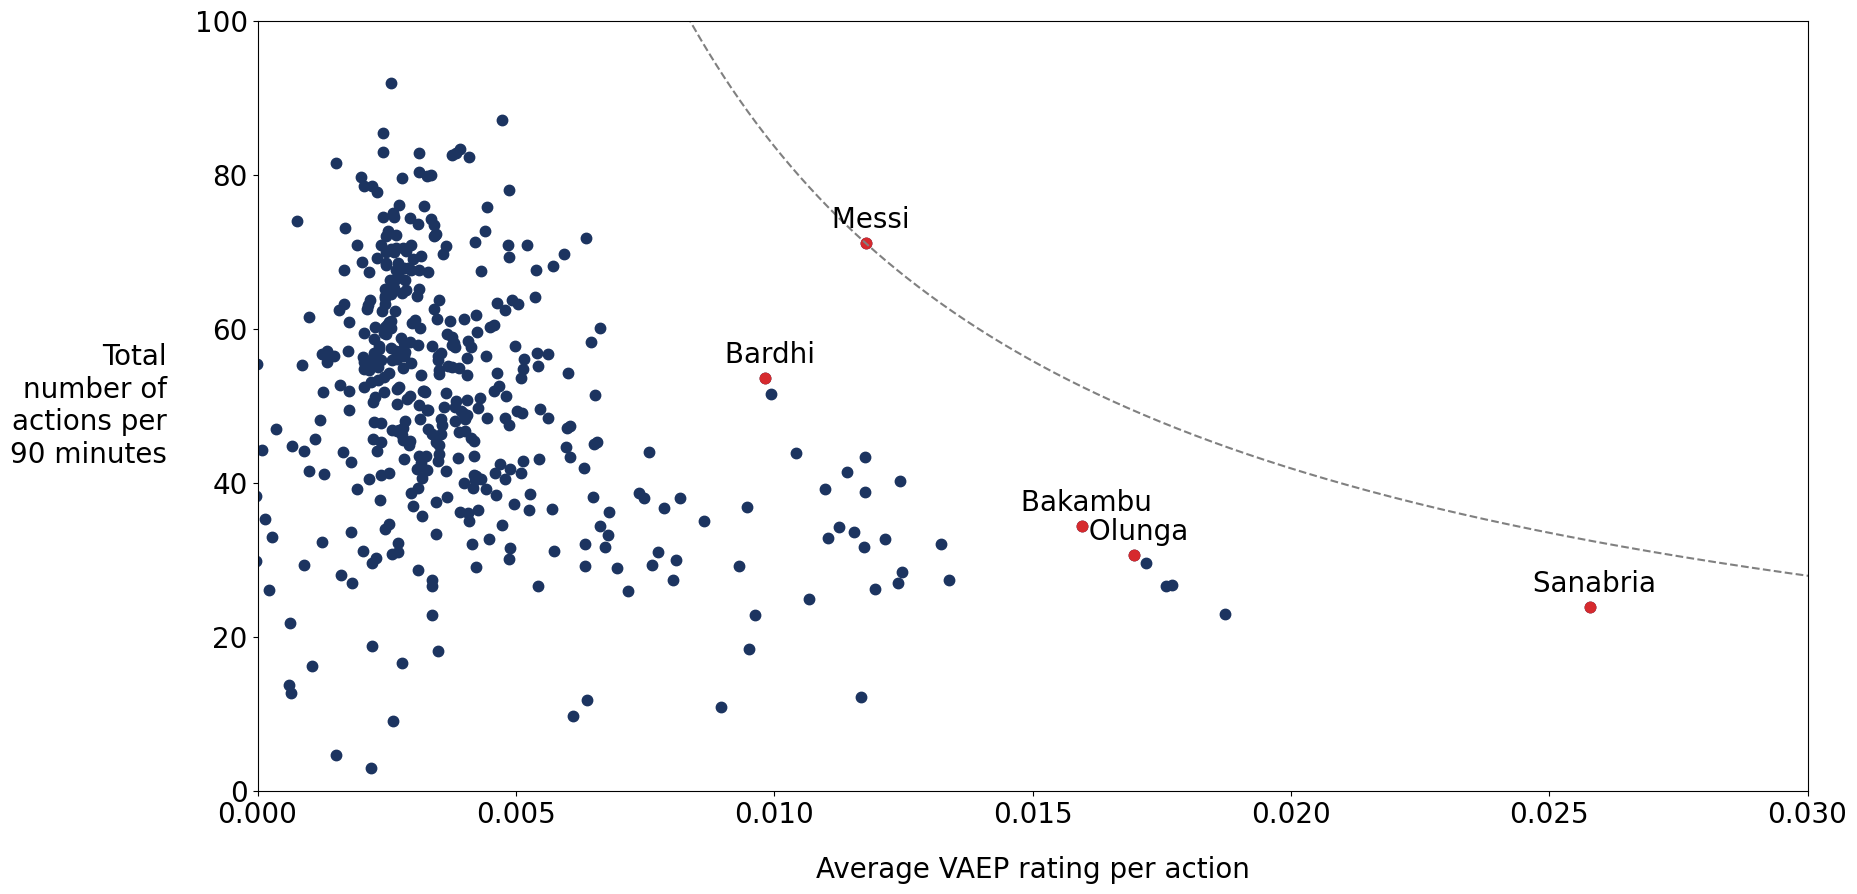

In [123]:
plt.figure(figsize=(20, 10))
x = list(df_ranking_p90['vaep_mean'])
y = list(df_ranking_p90['actions_p90'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

# Plot 5 best players
x_best = list(df_ranking_p90['vaep_mean'][0:5])
y_best = list(df_ranking_p90['actions_p90'][0:5])
names = list(df_ranking_p90['short_name'][0:5])
names = [name.split(".")[-1] for name in names]
plt.plot(x_best, y_best, '.', c='#D62A2E', markersize=15)
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i] + 2), fontsize=20, horizontalalignment='center')

best_player = x[0] * y[0]
yi = np.arange(0.1, 100, 0.1)
xi = [best_player / i for i in yi]
plt.plot(xi, yi, '--', c='grey')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0, 0.03)
plt.ylim(0, 100)
plt.xlabel('Average VAEP rating per action', labelpad=20, fontsize=20)
plt.ylabel('Total\nnumber of\nactions per\n90 minutes', rotation=0, labelpad=20,
            verticalalignment='center', horizontalalignment='right', fontsize=20)

plt.show()

## Risk - reward trade-off

Here we will look at the ratings for a player's successful actions and for the player's unsuccessful actions. In this way we can identify players that take more risk, and players that play less risky.

In [124]:
df_risk = pd.pivot_table(df_values, values='vaep_value', index=['player_id', 'short_name', 'team_name'],
                                              columns=['result_name'], aggfunc=np.sum,
                                              fill_value=0)[['success', 'fail']]
df_risk = df_risk.reset_index()
df_risk = df_risk[0:-1]
df_risk = pd.merge(df_risk, df_minutes_played, on=['player_id'])
for result in ['success', 'fail']:
    df_risk[result] = df_risk[result] / df_risk['minutes_played'] * 90

In [125]:
df_risk = df_risk[df_risk['minutes_played']>MIN_THRESHOLD]
df_risk['vaep_rating'] = df_risk['success'] + df_risk['fail']
df_risk.sort_values('fail')

,player_id,short_name,team_name,success,fail,minutes_played,vaep_rating
198,4440.0,Borja Valle,Real Club Deportivo de La Coruña,0.548992,-0.200549,525.793890,0.348443
94,3605.0,Jorge Molina,Getafe Club de Fútbol,0.184750,-0.184712,2886.306136,0.000038
277,20823.0,F. Vázquez,Sevilla FC,0.394157,-0.173329,1896.973010,0.220828
248,7908.0,Fernando Torres,Club Atlético de Madrid,0.410329,-0.168423,1041.510712,0.241907
134,3822.0,Rubén Blanco,Real Club Celta de Vigo,-0.248505,-0.166768,2052.730402,-0.415274
...,...,...,...,...,...,...,...
481,285491.0,F. Uzoho,Real Club Deportivo de La Coruña,0.088215,0.008735,474.294605,0.096951
556,450784.0,Óscar Melendo,Reial Club Deportiu Espanyol,0.154225,0.010657,719.062392,0.164882
165,4086.0,Bóveda,Real Club Deportivo de La Coruña,0.075648,0.015509,1222.835057,0.091157
411,237269.0,S. Lukić,Levante UD,0.148293,0.018700,1034.210928,0.166993


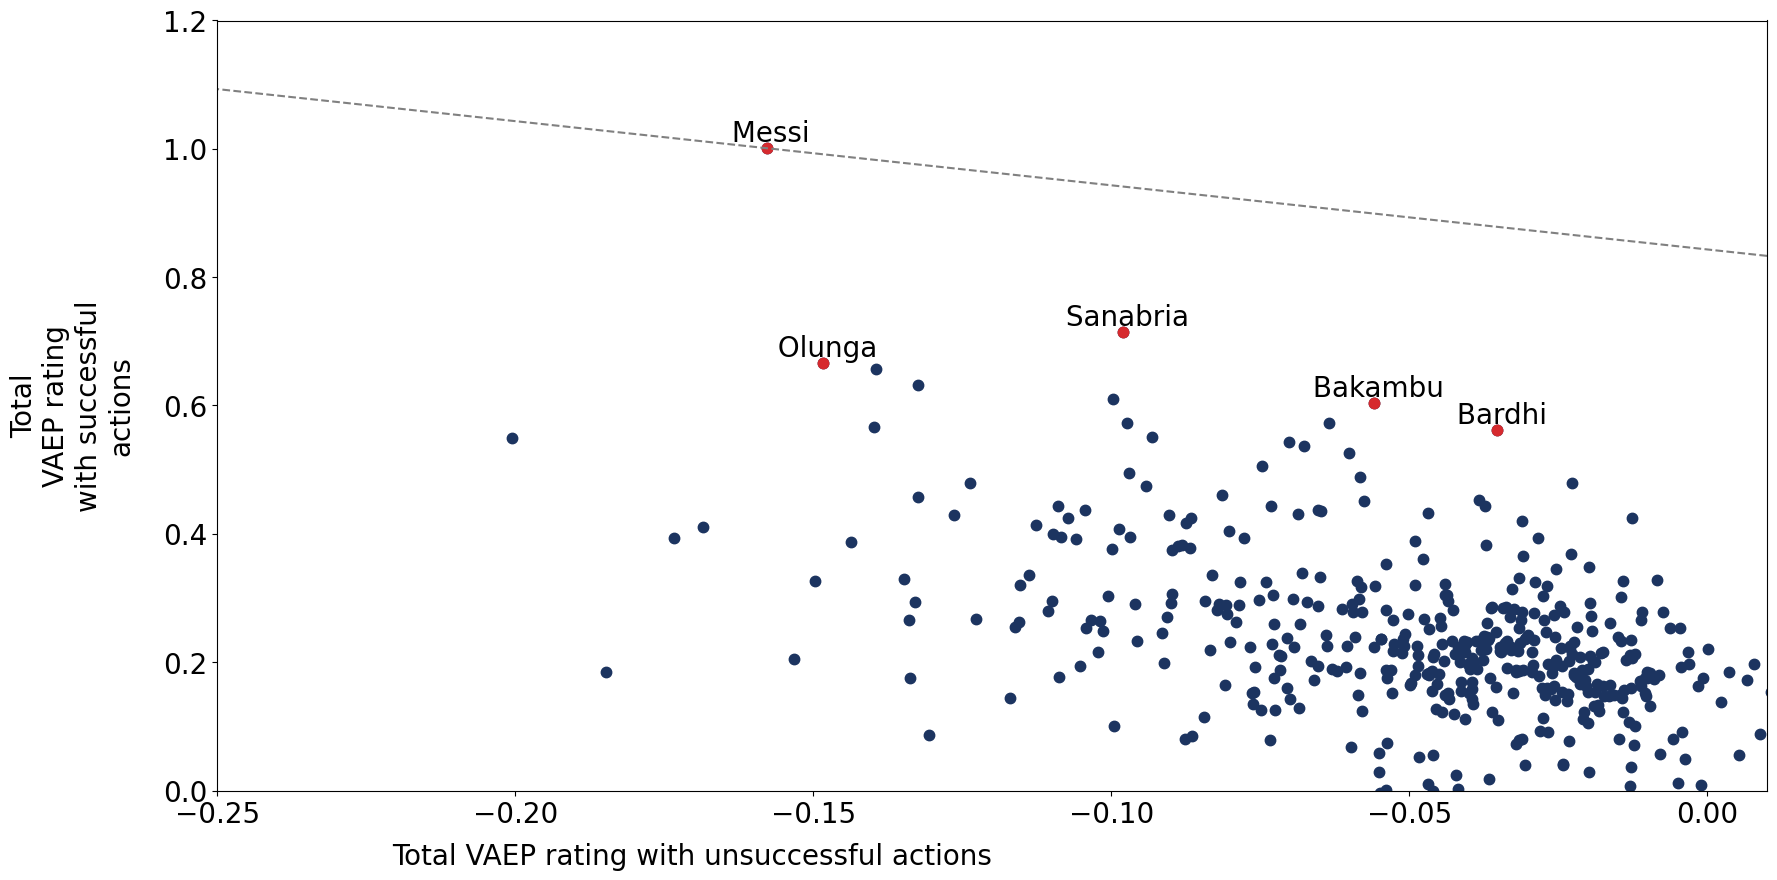

In [126]:
df_risk = df_risk.sort_values('vaep_rating', ascending=False)

plt.figure(figsize=(20, 10))
x = list(df_risk['fail'])
y = list(df_risk['success'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

# Plot 5 best players
x_best = list(df_risk['fail'][0:5])
y_best = list(df_risk['success'][0:5])
names = list(df_risk['short_name'][0:5])
names = [name.split(".")[-1] for name in names]
plt.plot(x_best, y_best, '.', c='#D62A2E', markersize=15)
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i] + 0.01), fontsize=20, horizontalalignment='center')

best_player = x[0] + y[0]
yi = np.arange(0.1, 2, 0.1)
xi = [best_player - i for i in yi]
plt.plot(xi, yi, '--', c='grey')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(-0.25, 0.01)
plt.ylim(0, 1.2)
plt.xlabel('Total VAEP rating with unsuccessful actions', rotation=0, labelpad=20,
            verticalalignment='center', horizontalalignment='right', fontsize=20)
plt.ylabel('Total\nVAEP rating\nwith successful\nactions', labelpad=20, fontsize=20)

plt.show()

## Rating per action type

In the next cells we will analyze the rating per player per action type.

In [127]:
df_rating_action = pd.pivot_table(df_values, values='vaep_value', index=['player_id', 'short_name', 'team_name'],
                                              columns=['type_name'], aggfunc=np.sum,
                                              fill_value=0, margins=True, margins_name='total')
df_rating_action = df_rating_action.reset_index()
df_rating_action = df_rating_action[0:-1]
df_rating_action = pd.merge(df_rating_action, df_minutes_played, on=['player_id'])
for action in df_values['type_name'].unique():
    df_rating_action[action] = df_rating_action[action] / df_rating_action['minutes_played'] * 90

In [128]:
df_rating_action[df_rating_action['minutes_played']>MIN_THRESHOLD].sort_values('shot',
                                                                               ascending=False).head(10)

,player_id,short_name,team_name,clearance,corner_crossed,corner_short,cross,dribble,foul,freekick_crossed,...,keeper_save,pass,shot,shot_freekick,shot_penalty,tackle,take_on,throw_in,total,minutes_played
399,225946.0,A. Sanabria,Real Betis Balompié,-0.004504,0.000000,0.000000,-0.005369,0.015202,0.007349,0.000000,...,0.0,-0.022205,0.639564,0.000000,0.000000,-0.002688,-0.003029,0.000000,6.164675,901.735926
41,3359.0,L. Messi,FC Barcelona,0.000000,0.000683,-0.013256,0.005960,0.041698,0.004724,0.006486,...,0.0,0.170285,0.502652,0.124671,-0.035983,0.000473,0.023711,0.000414,32.416279,3486.545778
281,22578.0,N. Sansone,Villarreal Club de Fútbol,0.011586,0.007223,-0.017818,-0.011991,0.026296,0.004174,-0.002529,...,0.0,0.026503,0.428657,0.000472,-0.011987,-0.004971,-0.000319,-0.000521,3.416458,673.019042
286,25472.0,C. Bakambu,Villarreal Club de Fútbol,0.003025,0.000000,0.000000,-0.001424,0.034311,0.040526,0.000000,...,0.0,0.038166,0.424800,0.000000,0.007887,-0.001058,0.001862,0.000000,7.897471,1297.283765
448,266885.0,M. Olunga,Girona FC,0.016480,0.000000,0.000000,0.014735,0.041847,0.038683,0.000000,...,0.0,-0.044847,0.424683,0.000000,0.000000,0.000000,0.016467,0.000000,2.664219,462.684560
249,7972.0,L. Suárez,FC Barcelona,-0.000060,0.000000,0.000241,-0.017157,0.056945,0.018202,0.000000,...,0.0,0.024429,0.419983,0.001527,-0.000212,-0.003388,-0.002922,0.000652,19.249691,3472.723903
252,8278.0,G. Bale,Real Madrid Club de Fútbol,0.001160,0.000000,0.000000,0.025676,0.005934,0.008573,0.000000,...,0.0,0.037347,0.407725,-0.002006,-0.008635,0.000124,-0.000547,-0.001016,12.588237,2403.149916
521,364820.0,Loren Morón,Real Betis Balompié,0.009377,0.000000,0.000000,-0.004236,0.046653,0.029376,0.000000,...,0.0,0.019798,0.406556,0.000000,0.000000,-0.000276,-0.000771,0.000750,6.172570,1092.796604
168,4131.0,Ángel,Getafe Club de Fútbol,0.003697,0.000000,0.000000,0.015640,0.047661,0.015331,0.000000,...,0.0,0.009989,0.386744,0.000000,-0.025031,-0.000900,0.005180,0.000249,12.343448,2373.549166
138,3840.0,Iago Aspas,Real Club Celta de Vigo,-0.003429,-0.004745,-0.013029,-0.003419,0.057954,0.007421,0.004377,...,0.0,0.076338,0.377118,0.018131,-0.022454,-0.000266,0.012248,0.000380,17.613704,3093.392216
